In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
import pycaret.anomaly as anomaly
from sklearn.model_selection import train_test_split

id : 샘플 아이디  
Gender : 전복 성별  
Lenght : 전복 길이  
Diameter : 전복 둘레  
Height : 전복 키   
Whole : Weight : 전복 전체 무게  
Shucked Weight : 껍질을 제외한 무게  
Viscra Weight : 내장 무게  
Shell Weight : 껍질 무게  
Target : 전복 나이  

In [135]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
sub=pd.read_csv("sample_submission.csv")

In [136]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [137]:
train.drop(columns=['id'],axis=1,inplace=True)
test.drop(columns=['id'],axis=1,inplace=True)

# Data info

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          1253 non-null   object 
 1   Lenght          1253 non-null   float64
 2   Diameter        1253 non-null   float64
 3   Height          1253 non-null   float64
 4   Whole Weight    1253 non-null   float64
 5   Shucked Weight  1253 non-null   float64
 6   Viscra Weight   1253 non-null   float64
 7   Shell Weight    1253 non-null   float64
 8   Target          1253 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 88.2+ KB


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924 entries, 0 to 2923
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2924 non-null   object 
 1   Lenght          2924 non-null   float64
 2   Diameter        2924 non-null   float64
 3   Height          2924 non-null   float64
 4   Whole Weight    2924 non-null   float64
 5   Shucked Weight  2924 non-null   float64
 6   Viscra Weight   2924 non-null   float64
 7   Shell Weight    2924 non-null   float64
dtypes: float64(7), object(1)
memory usage: 182.9+ KB


# EDA

## 결측치 체크

In [33]:
#결측치 없음
def check_null_values(df):
    if df.isnull().sum().sum()>0:
        for col in df.columns:
            print("%s : %d" %(col,df[col].isnull().sum()))
    else:
        print("0")
check_null_values(train)
check_null_values(test)

0
0


## 분포 확인

In [34]:
def distribution_feature(df):
    plt.figure(figsize=(10,6))
    i=0
    for col in df.columns:
        if col=='id':
            continue
        i+=1
        plt.subplot(3,3,i)
        sns.histplot(df[col],bins=10)

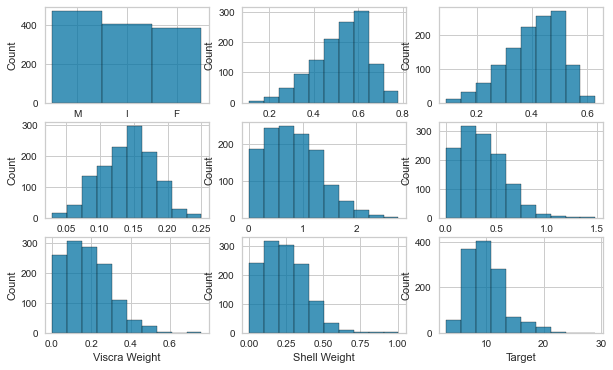

In [35]:
distribution_feature(train)

In [36]:
def distribution_feature_test(df):
    plt.figure(figsize=(10,6))
    i=0
    for col in df.columns:
        if col=='id':
            continue
        i+=1
        plt.subplot(2,4,i)
        sns.histplot(df[col],bins=10)

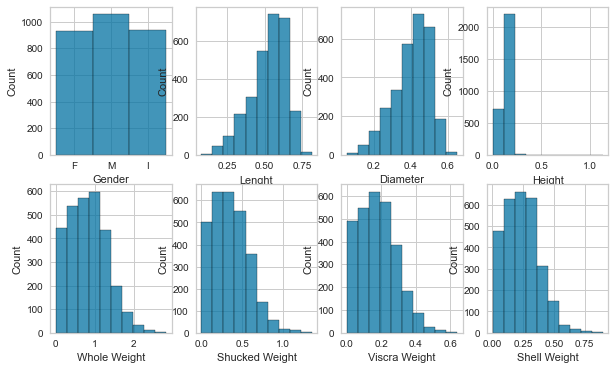

In [37]:
distribution_feature_test(test)

- 전부 log 처리 필요

In [38]:
def skewness(df):
    for col in df.columns:
        if col=='id' or col=='Gender':
            continue
        print("%s : %.5f" %(col,skew(df[col])))
        
print("train"+"-"*30)
skewness(train)
print("test"+"-"*30)
skewness(test)

train------------------------------
Lenght : -0.55976
Diameter : -0.52060
Height : -0.10843
Whole Weight : 0.58039
Shucked Weight : 0.79599
Viscra Weight : 0.68257
Shell Weight : 0.69905
Target : 1.15087
test------------------------------
Lenght : -0.67403
Diameter : -0.64755
Height : 4.15489
Whole Weight : 0.50699
Shucked Weight : 0.68411
Viscra Weight : 0.54849
Shell Weight : 0.58239


## 성별에 따른 비교
- Gender I의 경우 weight의 분포가 왼쪽으로 치우침

<AxesSubplot:xlabel='Gender', ylabel='Count'>

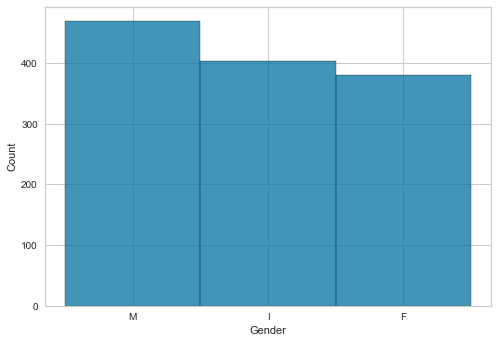

In [39]:
sns.histplot(train['Gender'])

In [40]:
sex_df=train.groupby(['Gender']).mean()
sex_df

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
Gender,,,,,,,,
F,0.579408,0.455316,0.157184,1.055354,0.446047,0.231962,0.307080,11.086842
I,0.431015,0.328119,0.108676,0.441911,0.196927,0.094717,0.130665,7.876238
M,0.556183,0.435704,0.151844,0.984917,0.427595,0.214050,0.280036,10.714286


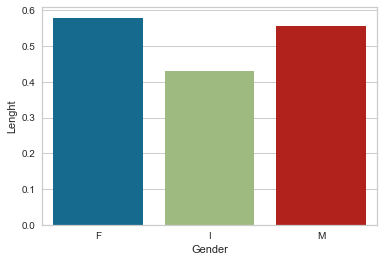

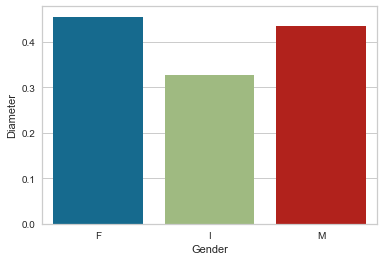

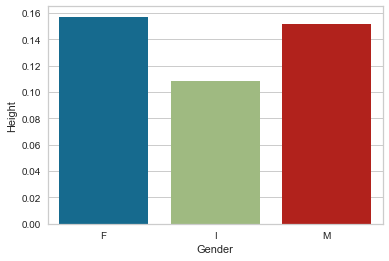

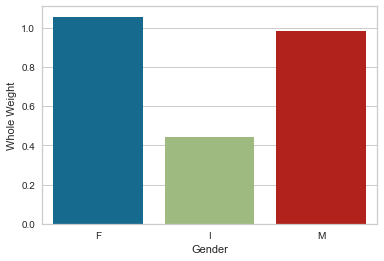

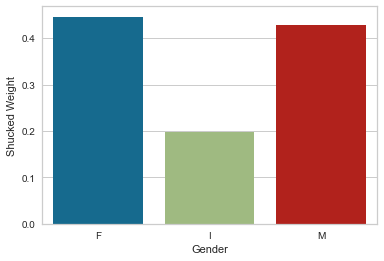

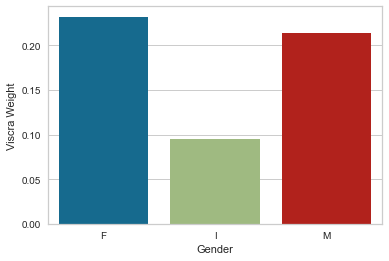

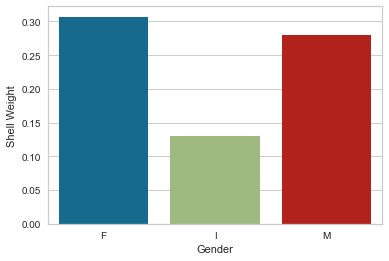

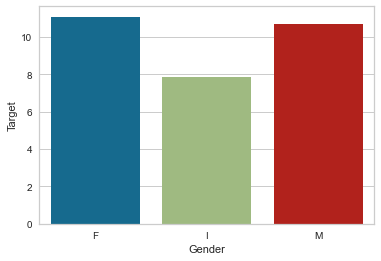

In [41]:

for col in train.columns:
    if col=='Gender':
        continue
    plt.figure(figsize=(6,4))
    sns.barplot(x=sex_df.index,y=sex_df[col],data=sex_df)


<Figure size 432x288 with 0 Axes>

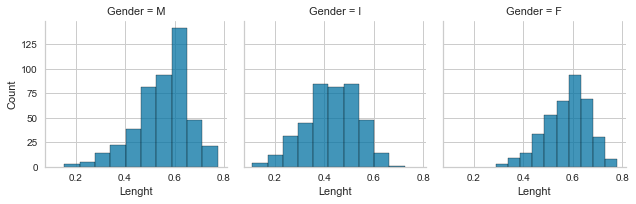

<Figure size 432x288 with 0 Axes>

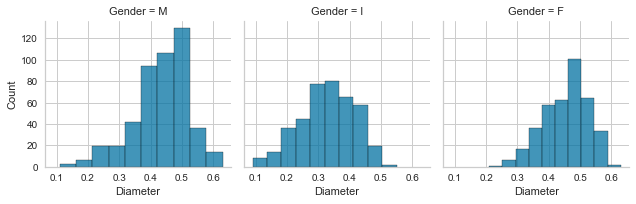

<Figure size 432x288 with 0 Axes>

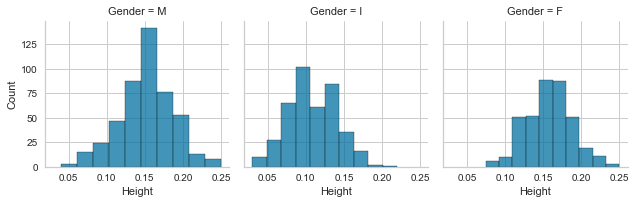

<Figure size 432x288 with 0 Axes>

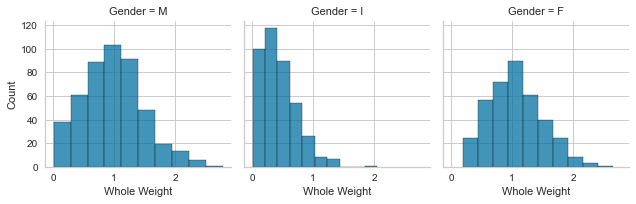

<Figure size 432x288 with 0 Axes>

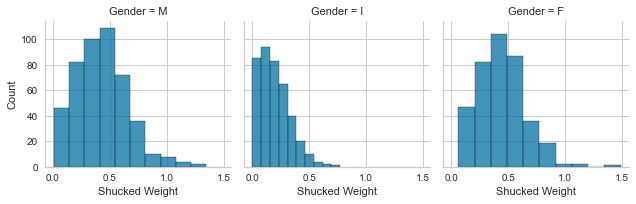

<Figure size 432x288 with 0 Axes>

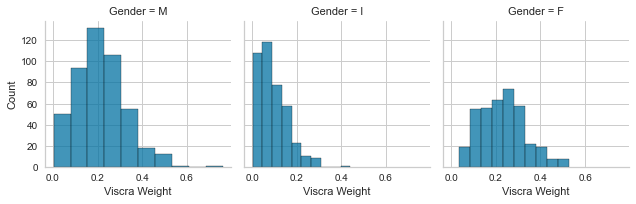

<Figure size 432x288 with 0 Axes>

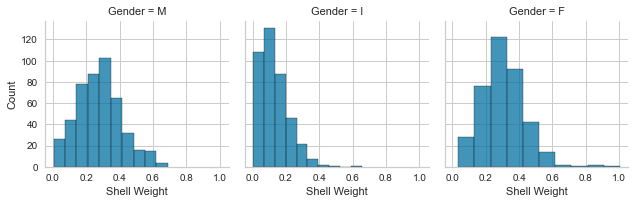

<Figure size 432x288 with 0 Axes>

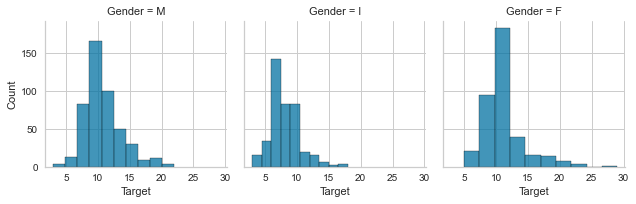

In [42]:
for col in train.columns:
    if col=='Gender':
        continue
    plt.figure(figsize=(6,4))
    g=sns.FacetGrid(train,col='Gender')
    g.map(sns.histplot,col,bins=10)

## feature 추가해보기

- 전체 무게에서 나머지 무게를 제외했을떄 0 보다 큰 무게를 extra_weight로 실시
- extra_weight<0이면 0으로 처리

In [138]:
train['extra_weight']=train['Whole Weight']-(train['Shucked Weight']+train['Viscra Weight']+train['Shell Weight'])
test['extra_weight']=test['Whole Weight']-(test['Shucked Weight']+test['Viscra Weight']+test['Shell Weight'])

In [139]:
train.loc[train['extra_weight']<0]['extra_weight']=0
test.loc[test['extra_weight']<0]['extra_weight']=0

## 상관관계 확인

<AxesSubplot:>

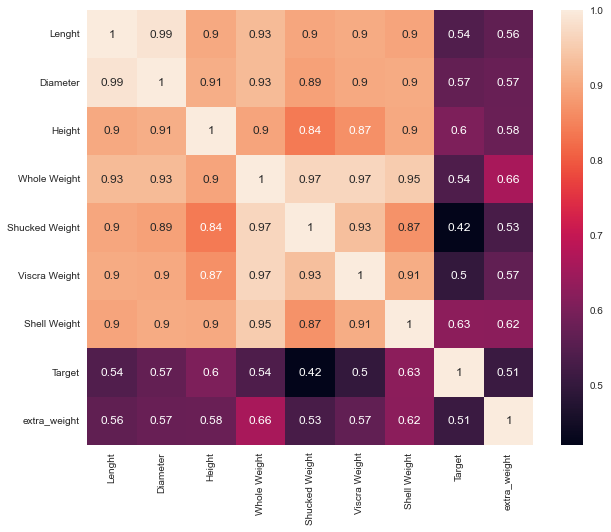

In [73]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(),annot=True)

# 이상치 확인

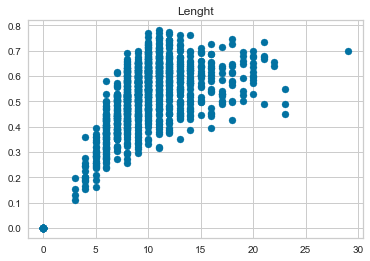

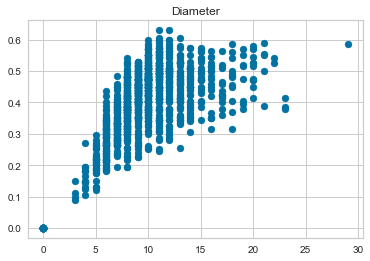

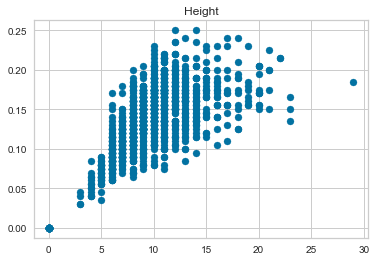

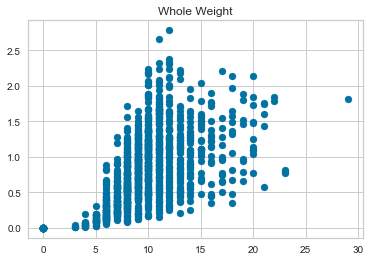

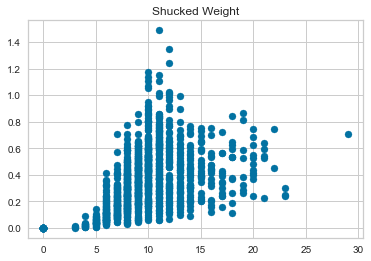

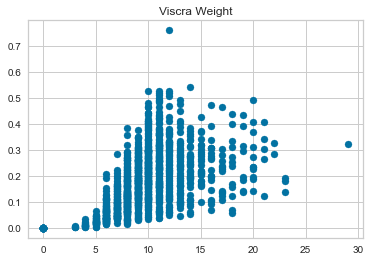

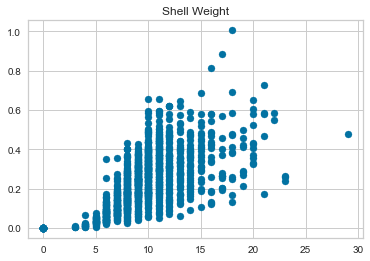

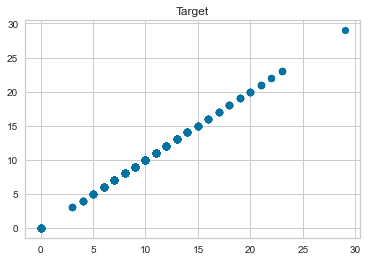

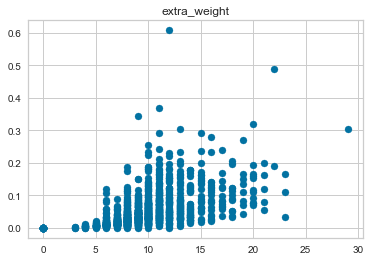

In [46]:
for col in train.columns:
    if col=='Gender':
        continue
    plt.figure(figsize=(6,4))
    plt.scatter(train['Target'],train[col])
    plt.title(col)

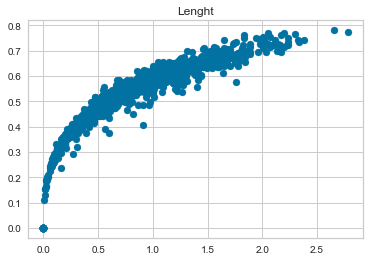

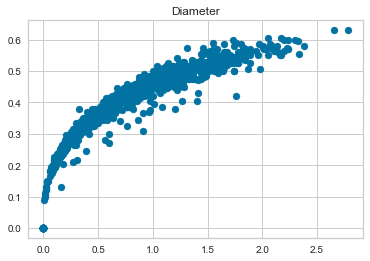

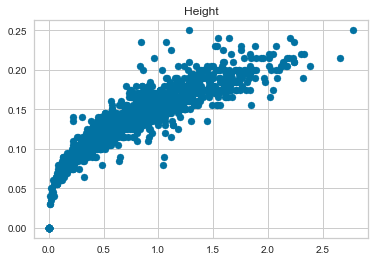

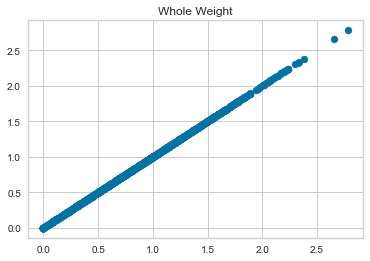

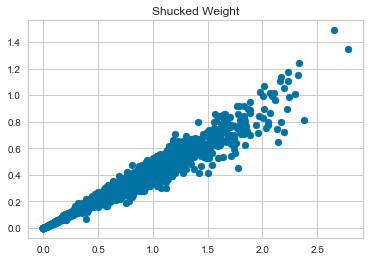

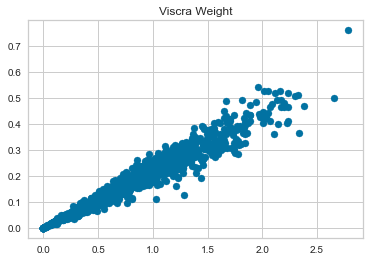

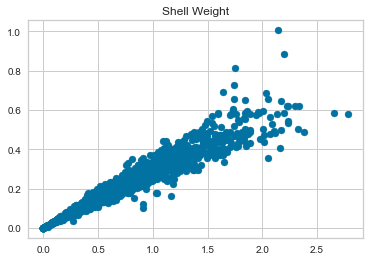

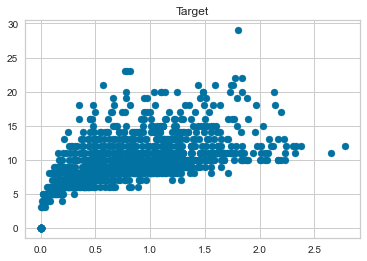

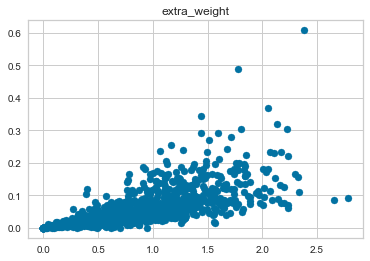

In [47]:
for col in train.columns:
    if col=='Gender':
        continue
    plt.figure(figsize=(6,4))
    plt.scatter(train['Whole Weight'],train[col])
    plt.title(col)

In [142]:
train.drop(train.loc[train['Target']>25].index,axis=0,inplace=True)

# log변환

In [143]:
train['Target']=np.log1p(train['Target'])
train['Whole Weight']=np.log1p(train['Whole Weight'])
train['Shucked Weight']=np.log1p(train['Shucked Weight'])
train['Viscra Weight']=np.log1p(train['Viscra Weight'])
train['Shell Weight']=np.log1p(train['Shell Weight'])
train['extra_weight']=np.log1p(train['extra_weight'])
train['Lenght']=np.log1p(train['Lenght'])
train['Diameter']=np.log1p(train['Diameter'])
train['Height']=np.log1p(train['Height'])

test['Shucked Weight']=np.log1p(test['Shucked Weight'])
test['Shell Weight']=np.log1p(test['Shell Weight'])
test['Viscra Weight']=np.log1p(test['Viscra Weight'])
test['Whole Weight']=np.log1p(test['Whole Weight'])
test['extra_weight']=np.log1p(test['extra_weight'])
test['Lenght']=np.log1p(test['Lenght'])
test['Diameter']=np.log1p(test['Diameter'])
test['Height']=np.log1p(test['Height'])

In [144]:
def skewness(df):
    for col in df.columns:
        if col=='id' or col=='Gender':
            continue
        print("%s : %.5f" %(col,skew(df[col])))
        
print("train"+"-"*30)
skewness(train)
print("test"+"-"*30)
skewness(test)

train------------------------------
Lenght : -0.77004
Diameter : -0.69929
Height : -0.19373
Whole Weight : 0.02005
Shucked Weight : 0.36602
Viscra Weight : 0.45254
Shell Weight : 0.37949
Target : -0.02392
extra_weight : -0.21411
test------------------------------
Lenght : -0.88621
Diameter : -0.82560
Height : 1.57500
Whole Weight : -0.06420
Shucked Weight : 0.28085
Viscra Weight : 0.34081
Shell Weight : 0.28551
extra_weight : 0.06136


# Categorical 변수 변환

In [145]:
gender=pd.get_dummies(train['Gender'])
train_df=pd.concat([train,gender],axis=1)
train_df

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target,extra_weight,F,I,M
0,M,0.473124,0.385262,0.108854,0.748582,0.331101,0.255417,0.270027,2.772589,0.113775,0,0,1
1,I,0.357674,0.273837,0.090754,0.320633,0.161268,0.076961,0.099393,2.197225,0.018331,0,1,0
2,I,0.457425,0.398776,0.178146,0.840057,0.425594,0.226338,0.343590,2.944439,0.115113,0,1,0
3,M,0.428530,0.340037,0.161268,0.820000,0.436964,0.282544,0.290428,2.639057,0.057325,0,0,1
4,I,0.270027,0.211071,0.086178,0.119559,0.046884,0.030529,0.039221,1.945910,0.007968,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,I,0.173953,0.135405,0.039221,0.037296,0.016365,0.006479,0.014889,1.609438,0.000000,0,1,0
1249,I,0.332894,0.270027,0.081580,0.275356,0.142367,0.049266,0.089384,2.079442,0.019803,0,1,0
1250,F,0.421994,0.343590,0.108854,0.573519,0.347836,0.151003,0.165514,2.079442,0.015381,1,0,0
1251,F,0.368109,0.288931,0.104360,0.361513,0.184403,0.103909,0.112882,1.945910,0.003992,1,0,0


In [146]:
gender=pd.get_dummies(test['Gender'])
test_df=pd.concat([test,gender],axis=1)
test_df

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,extra_weight,F,I,M
0,F,0.466874,0.385262,0.144100,0.751888,0.372598,0.163818,0.144100,0.290054,1,0,0
1,M,0.457425,0.371564,0.139762,0.655964,0.243730,0.166785,0.307485,0.103909,0,0,1
2,I,0.231112,0.186480,0.067659,0.092579,0.040662,0.018822,0.030044,0.005982,0,1,0
3,M,0.463734,0.378436,0.122218,0.742889,0.375006,0.186894,0.285179,0.105710,0,0,1
4,F,0.466874,0.381855,0.131028,0.748109,0.417064,0.218332,0.266203,0.045451,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2919,I,0.157004,0.099845,0.034401,0.033435,0.011929,0.008464,0.004988,0.008464,0,1,0
2920,I,0.361165,0.296394,0.108854,0.349247,0.200489,0.070924,0.100750,0.016365,0,1,0
2921,I,0.451076,0.371564,0.126633,0.584448,0.323170,0.132343,0.219136,0.025668,0,1,0
2922,I,0.378436,0.300105,0.113329,0.397769,0.176471,0.099845,0.144100,0.034884,0,1,0


# 모델 만들기 pycaret이용

In [147]:
X=train_df.drop(['Gender'],axis=1)
y=train_df['Target']

In [148]:
test_df.drop(['Gender'],axis=1,inplace=True)

In [149]:
from pycaret.regression import *
from sklearn import preprocessing
setup(data=X.copy(),
      target='Target',silent=True,normalize=False,session_id=1,data_split_stratify=False)
display()

,Description,Value
0,session_id,1
1,Target,Target
2,Original Data,"(1252, 12)"
3,Missing Values,0
4,Numeric Features,11
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(876, 11)"


In [150]:
top5=compare_models(n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.1378,0.0327,0.1800,0.5822,0.0530,0.0587,0.2130
et,Extra Trees Regressor,0.1401,0.0338,0.1830,0.5680,0.0540,0.0599,0.1630
huber,Huber Regressor,0.1401,0.0343,0.1844,0.5648,0.0546,0.0596,0.0290
lr,Linear Regression,0.1411,0.0342,0.1842,0.5642,0.0548,0.0604,1.5530
br,Bayesian Ridge,0.1414,0.0342,0.1843,0.5641,0.0548,0.0606,0.0120
lar,Least Angle Regression,0.1414,0.0346,0.1852,0.5596,0.0551,0.0605,0.0150
gbr,Gradient Boosting Regressor,0.1415,0.0348,0.1858,0.5546,0.0546,0.0602,0.0870
lightgbm,Light Gradient Boosting Machine,0.1464,0.0357,0.1883,0.5421,0.0556,0.0627,0.1660
ridge,Ridge Regression,0.1459,0.0364,0.1904,0.5374,0.0568,0.0628,0.0120
knn,K Neighbors Regressor,0.1468,0.0381,0.1940,0.5155,0.0574,0.0627,0.0150


In [151]:
rf=create_model("rf")

In [152]:
ensemble=ensemble_model(rf,n_estimators=5)

In [153]:
prediction=predict_model(ensemble,data=test_df)
prediction

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,extra_weight,F,I,M,Label
0,0.466874,0.385262,0.144100,0.751888,0.372598,0.163818,0.144100,0.290054,1,0,0,2.395262
1,0.457425,0.371564,0.139762,0.655964,0.243730,0.166785,0.307485,0.103909,0,0,1,2.651309
2,0.231112,0.186480,0.067659,0.092579,0.040662,0.018822,0.030044,0.005982,0,1,0,1.845776
3,0.463734,0.378436,0.122218,0.742889,0.375006,0.186894,0.285179,0.105710,0,0,1,2.554955
4,0.466874,0.381855,0.131028,0.748109,0.417064,0.218332,0.266203,0.045451,1,0,0,2.379174
...,...,...,...,...,...,...,...,...,...,...,...,...
2919,0.157004,0.099845,0.034401,0.033435,0.011929,0.008464,0.004988,0.008464,0,1,0,1.567187
2920,0.361165,0.296394,0.108854,0.349247,0.200489,0.070924,0.100750,0.016365,0,1,0,2.093023
2921,0.451076,0.371564,0.126633,0.584448,0.323170,0.132343,0.219136,0.025668,0,1,0,2.357692
2922,0.378436,0.300105,0.113329,0.397769,0.176471,0.099845,0.144100,0.034884,0,1,0,2.368400


In [154]:
pred=np.expm1(prediction['Label']).astype('int')

In [155]:
pred

0        9
1       13
2        5
3       11
4        9
        ..
2919     3
2920     7
2921     9
2922     9
2923    11
Name: Label, Length: 2924, dtype: int32

# modeling
- pycaret과 별개로 feature selection을 위한 모델 찾기


In [106]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,BayesianRidge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold,GridSearchCV,train_test_split

In [107]:
X=train_df.drop(['Gender','Target'],axis=1)
y=train_df['Target']

In [108]:
kfold=KFold(n_splits=5,shuffle=True,random_state=42)

In [109]:
models=[LinearRegression(),Ridge(),Lasso(),ElasticNet(),RandomForestRegressor(),GradientBoostingRegressor(),ExtraTreesRegressor(),
      XGBRegressor(),LGBMRegressor(),BayesianRidge()]

In [110]:
for model in models:
    nmae=[]
    for train_idx,val_idx in kfold.split(X,y):
        x_train=X.iloc[train_idx]
        y_train=y[train_idx]
        x_val=X.iloc[val_idx]
        y_val=y[val_idx]
        model.fit(x_train,y_train)
        pred=model.predict(x_val)
        pred=np.expm1(pred).astype('int')
        y_val=np.expm1(y_val).astype('int')
        score=NMAE(y_val,pred)
        nmae.append(score)
    print("model :{}, score :{}".format(model,np.mean(nmae)))

model :LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), score :0.16604921245868542
model :Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), score :0.17036639326417974
model :Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), score :0.25070474921311237
model :ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False), score :0.25070474921311237
model :RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,


- GBR 파인튜닝

In [79]:
params_grid={''n_estimators':np.arange(100,500,10),'subsample':np.arange(0.5,1.0,0.1),'random_state':[0],
            'min_samples_split':np.arange(10,70,10),'max_depth':np.arange(1,5,1),
            'max_leaf_nodes':np.arange(4,128,4),'loss':['absolute_error'],'learning_rate':np.arange(0.05,0.5,0.05),
            'min_samples_leaf'::np.arange(10,70,10),'max_features':np.arange(0.5,1.0,0.1)}
gbr=GridSearchCV(GradientBoostingRegressor(),param_grid=params_grid,cv=5,scoring="neg_mean_absolute_error")
gbr.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=60,
                          min_weight_fraction_leaf=0.0, n_estimators=40,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.8999999999999999,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)  
  score :0.1607844161672311                         

In [80]:
gbr.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=60,
                          min_weight_fraction_leaf=0.0, n_estimators=40,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.8999999999999999,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [81]:
nmae=[]
gbr=gbr.best_estimator_
for train_idx,val_idx in kfold.split(X,y):
    x_train=X.iloc[train_idx]
    y_train=y[train_idx]
    x_val=X.iloc[val_idx]
    y_val=y[val_idx]
    gbr.fit(x_train,y_train)
    pred=gbr.predict(x_val)
    pred=np.expm1(pred).astype('int')
    y_val=np.expm1(y_val).astype('int')
    score=NMAE(y_val,pred)
    nmae.append(score)
print(" score :{}".format(np.mean(nmae)))

 score :0.1607844161672311


# feature selection

In [111]:
import shap
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")

In [113]:
def evaluate(x_data,y_data):
    model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=60,
                          min_weight_fraction_leaf=0.0, n_estimators=40,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.8999999999999999,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)
    nmae=[]
    for train_idx,val_idx in kfold.split(x_data,y_data):
        x_train=x_data.iloc[train_idx]
        y_train=y_data[train_idx]
        x_val=x_data.iloc[val_idx]
        y_val=y_data[val_idx]
        model.fit(x_train,y_train)
        pred=model.predict(x_val)
        pred=np.expm1(pred).astype('int')
        y_val=np.expm1(y_val).astype('int')
        score=NMAE(y_val,pred)
        nmae.append(score)
    return np.mean(nmae)

In [128]:
def rfe(x_data,y_data,method,ratio=0.9,min_feats=4):
    features=x_data.columns.tolist()
    df=pd.DataFrame(columns=['model','n_feats','feats','score'])
    while True:
        model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=60,
                          min_weight_fraction_leaf=0.0, n_estimators=40,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.8999999999999999,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)
        nmae=[]
        x_train,x_val,y_train,y_val=train_test_split(x_data[features],y_data,test_size=0.3,random_state=0)
        model.fit(x_train,y_train)
        pred=model.predict(x_val)
        pred=np.expm1(pred).astype('int')
        y_val=np.expm1(y_val).astype('int')
        score=NMAE(y_val,pred)
        nmae.append(score)
        final_score=np.mean(nmae)
        n_feats=len(features)
        df=df.append({'model':model,'n_feats':n_feats,'feats':features,'score':final_score},ignore_index=True)
    
        
        if method=='perm':
            perm=permutation_importance(model,x_val,y_val,n_repeats=30,random_state=0,scoring='neg_mean_squared_error')
            feat_imp=pd.Series(perm.importances_mean,index=features).sort_values(ascending=True)
        
        elif method=='shap':
            masker = shap.maskers.Independent(data = x_data[features])
            explainer=shap.TreeExplainer(model,masker=masker)
            shap_values=explainer.shap_values(x_data[features])
            temp=np.abs(shap_values).mean(axis=0)
            feat_imp=pd.Series(np.mean(temp,axis=0),index=features).sort_values(ascending=False)
        next_n_feats=int(n_feats*ratio)
        if(next_n_feats<min_feats):
            break
        else:
            features=feat_imp.iloc[:next_n_feats].index.tolist()
    return df

## permutation_importance

In [115]:
perm_archive=rfe(X,y,'perm')

In [121]:
perm_archive['feats'][0]

['Lenght',
 'Diameter',
 'Height',
 'Whole Weight',
 'Shucked Weight',
 'Viscra Weight',
 'Shell Weight',
 'extra_weight',
 'F',
 'I',
 'M']

In [122]:
model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=60,
                          min_weight_fraction_leaf=0.0, n_estimators=40,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.8999999999999999,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)
x_train,x_val,y_train,y_val=train_test_split(X,y,test_size=0.3,random_state=0)
model.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=60,
                          min_weight_fraction_leaf=0.0, n_estimators=40,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.8999999999999999,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [123]:
#one_shot
perm=permutation_importance(model,x_val,y_val,n_repeats=30,random_state=0,scoring='neg_mean_squared_error')
feat_imp=pd.Series(perm.importances_mean,index=x_val.columns).sort_values(ascending=False)

In [124]:
for i in range(1,14):
    print(feat_imp.iloc[:i].index)
    print(i,evaluate(X[feat_imp.iloc[:i].index],y))

Index(['Shell Weight'], dtype='object')
1 0.17952029985589343
Index(['Shell Weight', 'Shucked Weight'], dtype='object')
2 0.16610079630489802
Index(['Shell Weight', 'Shucked Weight', 'extra_weight'], dtype='object')
3 0.16502331157164507
Index(['Shell Weight', 'Shucked Weight', 'extra_weight', 'Height'], dtype='object')
4 0.16766961339684217
Index(['Shell Weight', 'Shucked Weight', 'extra_weight', 'Height', 'I'], dtype='object')
5 0.16022693951881273
Index(['Shell Weight', 'Shucked Weight', 'extra_weight', 'Height', 'I',
       'Viscra Weight'],
      dtype='object')
6 0.16061568642136154
Index(['Shell Weight', 'Shucked Weight', 'extra_weight', 'Height', 'I',
       'Viscra Weight', 'Lenght'],
      dtype='object')
7 0.1605415351186851
Index(['Shell Weight', 'Shucked Weight', 'extra_weight', 'Height', 'I',
       'Viscra Weight', 'Lenght', 'Diameter'],
      dtype='object')
8 0.16080232429694363
Index(['Shell Weight', 'Shucked Weight', 'extra_weight', 'Height', 'I',
       'Viscra Weig

## shap

In [129]:
shap_archive=rfe(X,y,'shap')
shap_archive

,model,n_feats,feats,score
0,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",11,"[Lenght, Diameter, Height, Whole Weight, Shuck...",0.161155
1,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",9,"[Lenght, Diameter, Height, Whole Weight, Shuck...",0.161996
2,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",8,"[Lenght, Diameter, Height, Whole Weight, Shuck...",0.164518
3,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",7,"[Lenght, Diameter, Height, Whole Weight, Shuck...",0.16676
4,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",6,"[Lenght, Diameter, Height, Whole Weight, Shuck...",0.170404
5,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",5,"[Lenght, Diameter, Height, Whole Weight, Shuck...",0.168161
6,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",4,"[Lenght, Diameter, Height, Whole Weight]",0.186659


In [130]:
masker = shap.maskers.Independent(data = X)

In [132]:
explainer=shap.TreeExplainer(model,masker=masker)
shap_values=explainer.shap_values(X)
shap_values

array([[-0.00251369,  0.00544582,  0.00188756, ...,  0.        ,
         0.01225722,  0.00295891],
       [ 0.00270642,  0.02162256, -0.01985227, ...,  0.        ,
        -0.03784775, -0.00209555],
       [-0.00243776,  0.00821422,  0.01881394, ...,  0.        ,
        -0.01261512, -0.00215581],
       ...,
       [ 0.00559978,  0.01478431,  0.00293791, ...,  0.        ,
         0.00807679, -0.00175176],
       [-0.00454256,  0.02195745, -0.01646844, ...,  0.        ,
         0.04097489, -0.00209555],
       [-0.03396584,  0.01599651,  0.0175888 , ...,  0.        ,
         0.0095087 , -0.00215581]])

In [133]:
temp=np.abs(shap_values).mean(axis=0)
temp

array([0.00856337, 0.01588258, 0.01896667, 0.00754338, 0.04479733,
       0.01222348, 0.14205852, 0.04955583, 0.        , 0.0209137 ,
       0.00255537])

- 11개를 모두 넣었을때의 결과가 가장 좋다

# submission

In [157]:
sub['Target']=pred
sub

,id,Target
0,1,9
1,2,12
2,3,5
3,4,11
4,5,9
...,...,...
2919,2920,3
2920,2921,7
2921,2922,9
2922,2923,8
